In [584]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [585]:
import pandas as pd

In [586]:
import numpy as np

In [587]:
# Define function to compute saturation vapor pressure in Pa, given temperature in C.
def esat(TC):
    return(611.2*np.exp(17.67*TC/(TC+243.5)))

#=================

# Define function to compute saturation mixing ratio, given temperature in K and pressure in Pa
def wsat(TK,p):
    es = esat(TK-273.15)
    return(0.622*es/(p-es))

In [588]:
from scipy.constants import g, C2K, K2C

In [589]:
# Read sonde

with open('91408_2011_07_19_12.txt') as sonde_fp:
    for lineno, line in enumerate(sonde_fp):
        if 'Station information' in line:
            footer_start = lineno
        if '----' in line:
            header_end = lineno+1
    footer_end = lineno
    
sonde = pd.read_table('91408_2011_07_19_12.txt', sep='\s+', header=None, skiprows=range(header_end)+range(footer_start,footer_end+1),
              names=[
                'pressure',
                'height',
                'temperature',
                'dewpoint',
                'rh',
                'mixing_ratio'
                ],
               usecols=range(6)
             )
# Set pressure as index
sonde.set_index('pressure', drop=False, inplace=True)

# Remove incomplete rows
sonde.dropna(inplace=True)

# Remove extra columns
sonde.drop(['rh','mixing_ratio','height'], inplace=True, axis=1)

# Ensure monotonicity
non_monotonic = pd.np.nonzero(pd.np.diff(sonde.index) > 0)[0] + 1
sonde.iloc[non_monotonic] = pd.np.NAN
sonde.dropna(inplace=True)
assert sonde.index.is_monotonic_decreasing

# Convert hPa to Pa
sonde.index *= 100
sonde.pressure *= 100
print 'Read',sonde.shape[0],'rows'

Read 123 rows


In [671]:
assumed_levels = pd.DataFrame({'temperature':[-50.0], 'dewpoint':[-80.0], 'pressure':[100.0]}, index=[100.0])
assumed_levels.index.name = 'pressure'
assumed_levels

,dewpoint,pressure,temperature
pressure,,,
100.0,-80.0,100.0,-50.0


In [831]:
profile = pd.concat([assumed_levels, sonde], join='inner').sort_index()

In [832]:
while True:
    pres_locations_to_insert = np.flatnonzero((profile.pressure.values[:-1]/profile.pressure.values[1:]) < 0.9) + 1
    temp_locations_to_insert = np.flatnonzero((profile.temperature.diff()).abs() > 1.0)
    locations_to_insert = np.union1d(pres_locations_to_insert, temp_locations_to_insert)
    if len(locations_to_insert) == 0:
        break
    print 'Inserted another', len(locations_to_insert), 'new levels'
    profile = profile.append(
        profile.rolling(window=2).mean()
        .iloc[locations_to_insert]
        .set_index('pressure', drop=False)
    ).sort_index()

Inserted another 56 new levels
Inserted another 49 new levels
Inserted another 32 new levels
Inserted another 32 new levels
Inserted another 7 new levels
Inserted another 5 new levels
Inserted another 1 new levels


In [844]:
#standard_profile = pd.DataFrame({k:np.interp(levels, profile.index, profile[k].values) for k in profile}, index=levels)
standard_profile = profile.copy()

In [845]:
standard_profile.tail()

,pressure,temperature,dewpoint
pressure,,,
97670.0,97670.0,24.90,23.00
98335.0,98335.0,25.45,23.15
99000.0,99000.0,26.00,23.30
100000.0,100000.0,26.40,22.50
100700.0,100700.0,26.80,24.10


In [846]:
#TODO interpolate

In [847]:
standard_profile['q_vap'] = 0.622 * (standard_profile.dewpoint.apply(esat) / standard_profile.pressure)

In [848]:
means = standard_profile.rolling(window=2).mean().dropna()
deltas = standard_profile.diff().rename(columns = lambda x: 'delta_'+x).dropna()
layers = means.join(deltas).reset_index(drop=True)

In [878]:
layers['mass'] = layers.delta_pressure / g

In [879]:
layers['wvmass'] = layers.q_vap*layers.mass

In [902]:
layers['delta_z'] = (287.06*layers.temperature.iloc[1:].apply(C2K)
                     *(1.+0.61*layers.q_vap.iloc[1:])
                     *log(layers.pressure.values[1:]/layers.pressure.values[:-1])/9.80665)
layers = layers.iloc[1:]

In [1044]:
z = layers.delta_z.sort_index(ascending=False).cumsum()
z[-1] = 0
layers['z'] = z.sort_index().rolling(window=2).mean()

In [1045]:
layers['rho'] = layers.mass / layers.delta_z
layers['rho_wv'] = layers.wvmass / layers.delta_z

In [1160]:
sum( x.wvmass for x in weight_shell.Atmosphere )

57.74604056251214

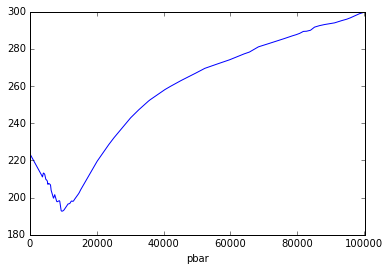

In [1181]:
atmos = (pd.DataFrame(
        [{key:getattr(x, key) for key in ['Zbar','pbar','Tbar','rho','rhowv','DZ','qbar','mass','wvmass']}
         for x in weight_shell.Atmosphere])
         .set_index('pbar', drop=False).sort_index())
#atmos.wvmass.sum()#.plot()
atmos.Tbar.plot()

In [1047]:
import gasabsr98

In [1048]:
f = 54.4000

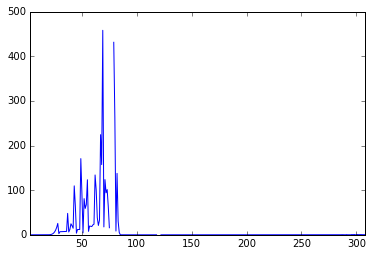

In [1049]:

            # t(z) = e^-tau(z)
#np.exp(
# tau(z) = integral from top to z of tau
#-layers.tau.values[::-1]#.cumsum()
#)
layers.tau.plot()

In [1148]:
def get_weighting_function(f):
    truncated_layers = layers.iloc[100:].copy()
    truncated_layers['ke_air'] = truncated_layers.apply(lambda s: gasabsr98.gasabsr98(f,C2K(s.temperature), s.rho_wv, s.pressure)[0], axis=1)
    truncated_layers['ke_wv'] = truncated_layers.apply(lambda s: gasabsr98.gasabsr98(f,C2K(s.temperature), s.rho_wv, s.pressure)[1], axis=1)
    
    truncated_layers['tau'] = (truncated_layers.ke_air*truncated_layers.mass + truncated_layers.ke_wv*truncated_layers.wvmass)
    return -(-truncated_layers.set_index('z').tau.sort_index(ascending=True).cumsum()).apply(np.exp).diff().dropna()

In [1191]:
def get_weighting_function(f):
    atmos['ke_air'] = atmos.apply(lambda s: gasabsr98.gasabsr98(f, s.Tbar, s.rhowv, s.pbar)[0], axis=1)
    atmos['ke_wv'] = atmos.apply(lambda s: gasabsr98.gasabsr98(f,s.Tbar, s.rhowv, s.pbar)[1], axis=1)
    
    atmos['tau'] = (atmos.ke_air*atmos.mass + atmos.ke_wv*atmos.wvmass)
    return -(-atmos.set_index('Zbar').tau.sort_index(ascending=False).cumsum()).apply(np.exp).diff().dropna() / atmos.set_index('Zbar').DZ

In [1192]:
(layers.wvmass).sum()

7737.1295607456359

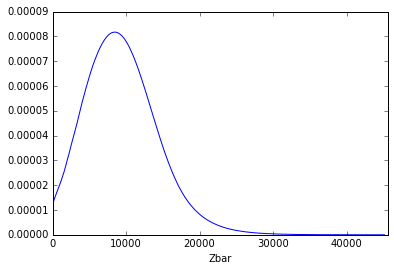

In [1193]:
get_weighting_function(f).plot()

In [1194]:
amsu_a = pd.Series(
    {
        3:  50.3000,
        4:  52.8000,
        5:  53.7110,
        6:  54.4000,
        7:  54.9400,
        8:  55.5000,
        9:  57.2900,
        10: 57.5070
    }
)

amsu_b = pd.Series(
    {
       16: 89.00,
        17: 150.0,
        18: 184.31,
        19: 186.31,
        20: 190.31
    }
)

In [1195]:
weighting_functions_a = pd.DataFrame({ channel:get_weighting_function(amsu_a[channel]).ix[:400000.] for channel in amsu_a.index})
weighting_functions_b = pd.DataFrame({ channel:get_weighting_function(amsu_b[channel]).ix[:400000.] for channel in amsu_b.index})

(0, 40000)

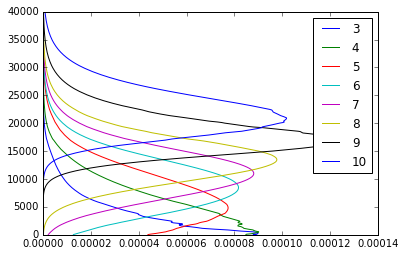

In [1196]:
plot(weighting_functions_a.values, weighting_functions_a.index)
#plot(weighting_functions_b, weighting_functions_b.index)
legend(amsu_a.index, loc='best')
ylim([0,40000])